In [1]:
import bayesfast as bf
import numpy as np

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38851 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 540.15 GB


In [3]:
a = 5
b = 0.5

def f_0(x):
    return np.linalg.norm(x, 2, -1)

def j_0(x):
    '''not actually used'''
    foo = x / np.linalg.norm(x, 2, -1)
    return foo if np.all(np.isfinite(foo)) else np.ones_like(foo)

def f_1(x):
    return -(x - a)**2 / b

def j_1(x):
    return -2 * (x - a) / b

m_0 = bf.Module(f_0, input_vars='in', output_vars='model')
m_1 = bf.Module(f_1, j_1, input_vars='model', output_vars='logp')
d_0 = bf.Density(module_list=[m_0, m_1], var_dims=[2], input_vars='in', 
                 density_name='logp')

s_0 = bf.modules.PolyModel('linear', 2, 1, input_vars='in', 
                           output_vars='model')
s_1 = bf.modules.PolyModel('quadratic', 2, 1, input_vars='in',
                           output_vars='model')
opt_0 = bf.recipe.OptimizeStep(s_0, hmc_options={'n_iter':1500, 'n_warmup':500},
                               fit_options={'use_decay': True})
sam_0 = bf.recipe.SampleStep(s_1, alpha_n=5, reuse_steps=0, 
                             sample_options={'n_iter':1500, 'n_warmup':500},
                             fit_options={'use_decay': True}, logp_cutoff=False,
                             adapt_metric=True)
sam_1 = bf.recipe.SampleStep(s_1, alpha_n=5, reuse_steps=1, 
                             sample_options={'n_iter':1500, 'n_warmup':500},
                             fit_options={'use_decay': True}, logp_cutoff=False,
                             adapt_metric=True)

x_0 = bf.utils.random.multivariate_normal([10, 10], np.eye(2), 20)
r_0 = bf.recipe.Recipe(density=d_0, client=client, optimize=opt_0, 
                       sample=[sam_0] * 5 + [sam_1] * 5, 
                       x_0=x_0, random_state=0)

In [4]:
r_0.run()

 OptimizeStep proceeding: iter #0 finished.
 OptimizeStep proceeding: iter #1 finished, while delta_pp = 0.672, delta_pq = 0.023.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [5.2553014  2.39156998], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)
/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [5.13965748 2.33932649], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #2 finished, while delta_pp = 0.361, delta_pq = 0.001.
 OptimizeStep proceeding: iter #3 finished, while delta_pp = 0.378, delta_pq = 0.001.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [4.98670131 2.27021781], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)
/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [4.8283927  2.19869076], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #4 finished, while delta_pp = 0.273, delta_pq = 0.001.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [4.65886496 2.12209463], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #5 finished, while delta_pp = 0.158, delta_pq = 0.000.


/global/u2/h/hejia/bayesfast/bayesfast/utils/laplace.py:76: RuntimeWarning: the optimization stopped at [4.6109005  2.10223375], but probably it has not converged yet.
  'converged yet.'.format(opt.x), RuntimeWarning)


 OptimizeStep proceeding: iter #6 finished, while delta_pp = 0.019, delta_pq = -0.000.

 ***** OptimizeStep finished. ***** 

 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.01 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.04 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.08 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.16 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 0.90 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.06 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 0.95 seconds.
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.12 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 0.92 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 0.99 seconds

In [6]:
r_0.n_call

342

Removed no burn in


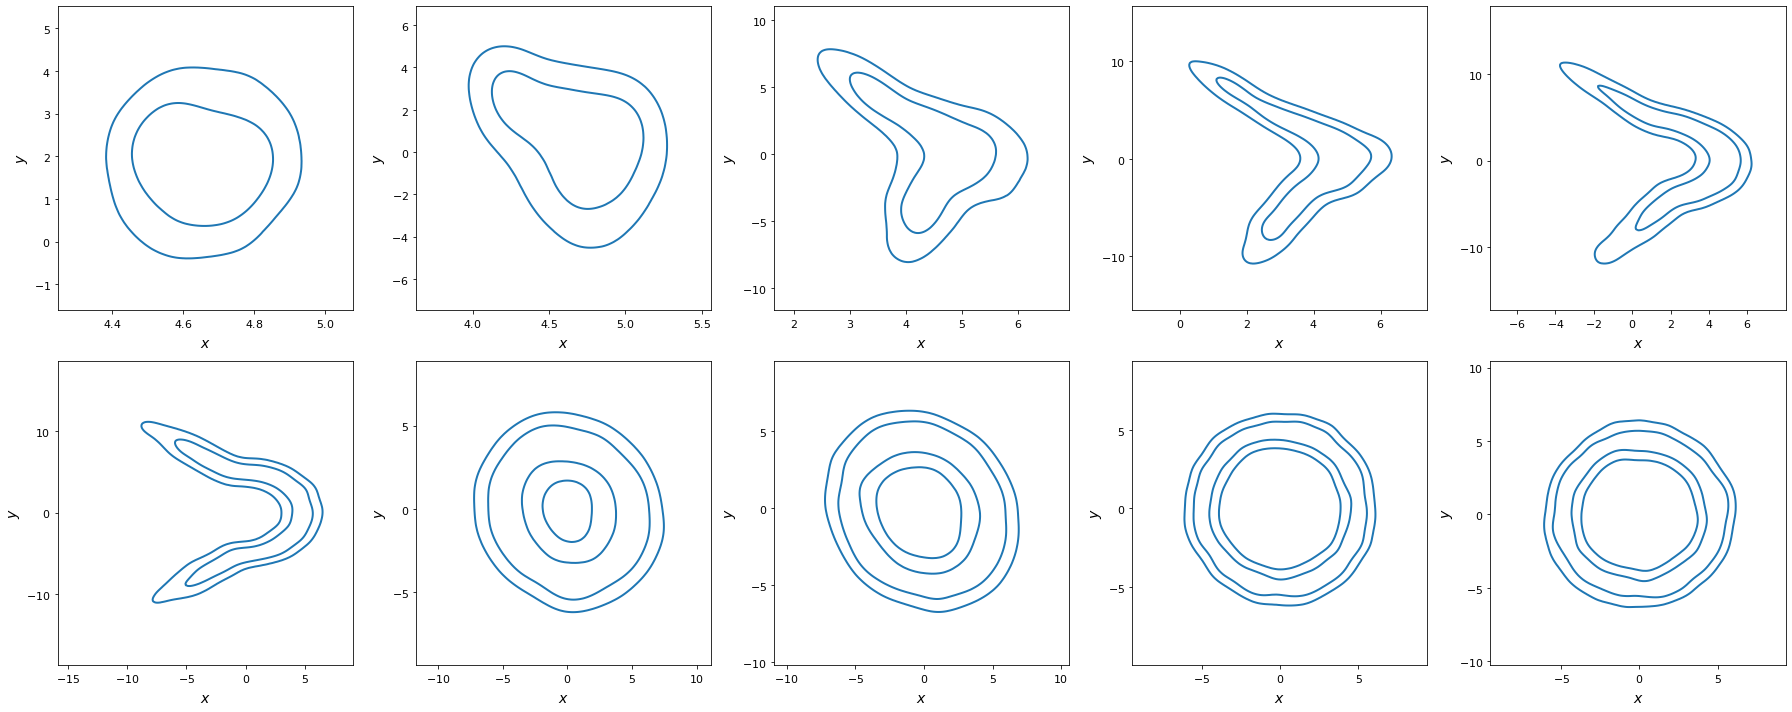

In [8]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

g = plots.get_subplot_plotter(subplot_size=5)
sa = MCSamples(samples=np.concatenate([si.samples.reshape((-1, 2)) for si in 
               r_0.result.data.sample], axis=-1), names=['x_{}'.format(i) for i 
               in range(20)], labels=['x', 'y'] * 10)
g.plots_2d(sa, param_pairs=[['x_{}'.format(i), 'x_{}'.format(i + 1)] for i in 
           range(0, 20, 2)], nx=5, colors=['tab:blue'], lws=[2])

plt.show()